In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [106]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


In [108]:


# Define data transforms for train, validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}




In [ ]:


# Define the dataset directory (adjust this path to your Kaggle input path)
data_dir = '/kaggle/input/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset'

# Create the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
print("Total images:", len(full_dataset))
class_names = full_dataset.classes
num_classes = len(class_names)
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_counts[i]} images")



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


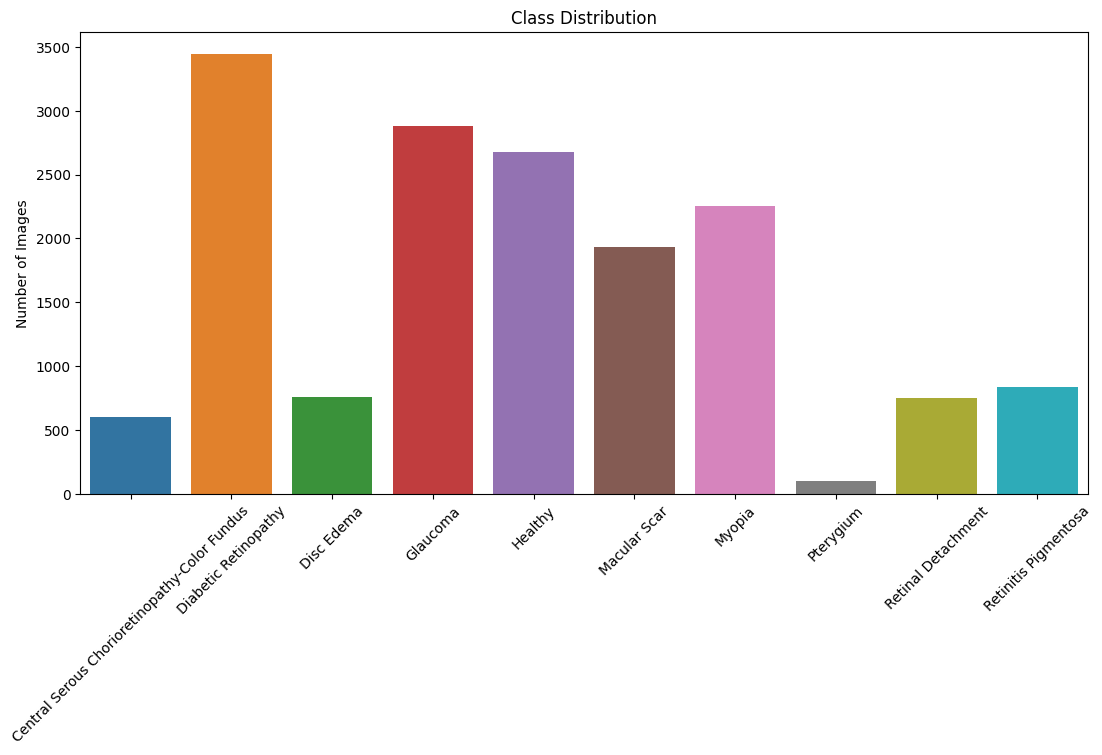

In [115]:
# Plot class distribution
class_counts = {}
for _, label in full_dataset.imgs:
    class_name = full_dataset.classes[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

plt.figure(figsize=(13, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.show()

In [122]:
# Split dataset: 70% train, 15% validation, 15% test
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size   = int(0.20 * dataset_size)
test_size  = dataset_size - train_size - val_size


In [123]:

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],
                                                          generator=torch.Generator().manual_seed(seed))

In [124]:

# Update transforms for validation and test sets
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']


In [125]:

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))


Train size: 11369
Validation size: 3248
Test size: 1625


In [126]:

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [128]:

from torchvision.models import VGG16_Weights

# Load pre-trained VGG16 model with the updated 'weights' argument
model = models.vgg16(weights=VGG16_Weights.DEFAULT)

# Freeze the feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier for our number of classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

In [129]:

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [130]:

num_epochs = 10
train_losses, val_losses = [], []
train_acc_history, val_acc_history = [], []

In [131]:

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    # Training Phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Update statistics
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_losses.append(epoch_loss)
    train_acc_history.append(epoch_acc.item())
    
    # Validation Phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_val_loss = running_loss / val_size
    epoch_val_acc = running_corrects.double() / val_size
    val_losses.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")


Epoch 1/10
Train Loss: 1.1805 Acc: 0.5715 | Val Loss: 0.8905 Acc: 0.6626
Epoch 2/10
Train Loss: 0.7667 Acc: 0.7155 | Val Loss: 0.7331 Acc: 0.7248
Epoch 3/10
Train Loss: 0.5935 Acc: 0.7792 | Val Loss: 0.6141 Acc: 0.7642
Epoch 4/10
Train Loss: 0.4771 Acc: 0.8215 | Val Loss: 0.6679 Acc: 0.7445
Epoch 5/10
Train Loss: 0.3969 Acc: 0.8518 | Val Loss: 0.5878 Acc: 0.7848
Epoch 6/10
Train Loss: 0.3515 Acc: 0.8722 | Val Loss: 0.6267 Acc: 0.7765
Epoch 7/10
Train Loss: 0.3044 Acc: 0.8894 | Val Loss: 0.5702 Acc: 0.7937
Epoch 8/10
Train Loss: 0.2721 Acc: 0.9018 | Val Loss: 0.5898 Acc: 0.7894
Epoch 9/10
Train Loss: 0.2639 Acc: 0.9061 | Val Loss: 0.5928 Acc: 0.7968
Epoch 10/10
Train Loss: 0.2322 Acc: 0.9144 | Val Loss: 0.6352 Acc: 0.7916
